### SVM 线性可分 (hard margin)


该实例主要解释如何在SVM hard margin方案内通过使用cvxopt来完成二次规划的问题。 
代码本身并不是自解释的，所以借用ipynb注释求解过程。

代码主要参考了： http://www.galoreinoso.com/2016/04/05/code-python-svm-binary-classifier/  <br>
原理主要参考：李航的统计学习方法,以及在线视频：https://www.youtube.com/watch?v=eHsErlPJWUU&list=PLnIDYuXHkit4LcWjDe0EwlE57WiGlBs08&index=14

我们要用到解决二次规划问题的Python包，cxvopt<br>
**Note：** 利用二次规划的方式需要构建较大的矩阵，对于数据量 > 10000 的场景下，不太实用，这里只是感受一下SVM hard-margin的数学解法。

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cvxopt
import seaborn as sns

代码分成3块，1)数据的生成，2)SVM分类，以及二次规划（重点) 3)图示分类结果

#### 数据生成
我们先生成2个数据点作为划分线。然后产生20个随机点(x1_input, x2_input)，按划分线判定其标签为+1还是-1(output)
x1, x2 分别代表一个点的2个维度。**(point0=[x1[0], x2[0]])**

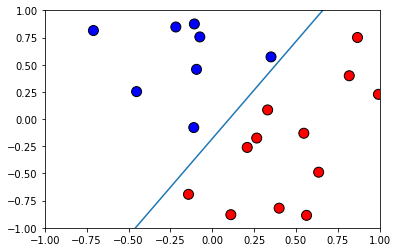

In [121]:
# Generating two points to construct the line
x1_targetf = np.random.uniform(-1,1,2)
x2_targetf = np.random.uniform(-1,1,2)
 
# Computing the slope m and the y-intercept b
m = (x2_targetf[1]-x2_targetf[0])/(x1_targetf[1]-x1_targetf[0])
b_target = x2_targetf[0] - m * x1_targetf[0]
 
# Computing the x2 value of the extremities of the line knowing that the x1
# values range is [-1, 1]
x2_lefttargetf = m*(-1) + b_target
x2_righttargetf = m*(1) + b_target
 
# Plot of target function
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.plot([-1,1], [x2_lefttargetf,x2_righttargetf])
plt.axis((-1,1,-1,1))

# Generating N training data points
N = 20
x1_input = np.random.uniform(-1,1,N)
x2_input = np.random.uniform(-1,1,N)
 
y_output = []
 
# Computing the y_output (class or category) from the target function
for index, each in enumerate(x1_input):
    # Computing the value of x2 if it was on the line
    x2_line = m*(each) + b_target
 
    # Checking the value of x2 corresponding to that x1 with the x2 from the line
    # Assigning a -1 or +1 class to it
    if x2_input[index] > x2_line:
        y_output.append(-1.0)
    else:
        y_output.append(1.0)
 
# Plotting the training points
plt.scatter(
    x1_input,
    x2_input,
    c=y_output,
    cmap='bwr',
    alpha=1,
    s=100,
    edgecolors='k'
    )


#### 完成分类

这里我们要完成的最主要的工作是求解<br>

$$\min_{\alpha} \frac{1}{2}\sum_{i,j=1}^{N}\alpha_i\alpha_jy_iy_j(x_i\cdot x_j) - \sum_{i=1}^{N}\alpha_i$$

$$s.t. \sum_{i=1}^{N}\alpha_iy_i = 0$$

$$\alpha_i \geqslant 0, i = 1, 2, ..., N$$

cvxopt 关于二次规划的调用公式为：http://cvxopt.org/userguide/coneprog.html#quadratic-programming<br>

$$ \min_{x} \frac{1}{2}x^TPx + q^Tx$$
$$ s.t. Gx \leq h $$
$$ Ax = b$$



该公式中，已知量为$y_iy_j(x_i\cdot x_j)$, 未知量为$\alpha_i\alpha_j$, 我们需要构造P, q, G, h, A 和 b 


P, q 的构造：

$$ \min_\alpha \frac{1}{2} \alpha^T P \alpha + (-1^T) \alpha $$

$$ 
  \min_\alpha \frac{1}{2} \alpha^T 
  \left[
  \begin{matrix}
   y_1y_1x_1^Tx_1 & y_1y_2x_1^Tx_2 & ... & y_1y_Nx_1^Tx_N \\
   y_2y_1x_2^Tx_1 & y_2y_2x_2^Tx_2 & ... & y_2y_Nx_2^Tx_N \\
    ...           &    ...         & ... &   ...          \\
   y_Ny_1x_N^Tx_1 & y_Ny_2x_N^Tx_2 & ... & y_Ny_Nx_N^Tx_N 
  \end{matrix}
  \right] 
  \alpha + (-1^T) \alpha
$$



P matrix is constructed by doing the outer product between the category label vector and itself, then multiplying it with the Gram matrix of the N data points. 

In [122]:
X_svm = np.column_stack((x1_input, x2_input))
y_output = np.array(y_output)

这里，X_svm的存储格式是
$\left[
 \begin{matrix}
  --- x_1 ---, \\ 
  --- x_2 ---, \\
  ...          \\
  --- x_N ---
  \end{matrix}
  \right]
$
相当于标准定义上的已转置的X，<br>所以在构造gram matrix的时候，不是$x^Tx$, 而是$x x^T$

In [123]:
# Build N*N Gram matrix
K = np.dot(X_svm, X_svm.T)
print(K.shape)
#print(K)

(20, 20)


一下代码是参考原始文件，检查gram matrix是否正确生成。

In [124]:
# Initializing the N x N Gram matrix
K_orig = np.zeros(shape = (
    len(x1_input),
    len(x1_input)
    ))
 
# Computing the inner products for each pair of vectors
for i in range(len(x1_input)):
    for j in range(len(x1_input)):
        K_orig[i,j] = np.dot(X_svm[i], X_svm[j])
        
#K_orig

In [125]:
y_out = np.outer(y_output, y_output)
print(y_out.shape)
#y_out

(20, 20)


In [126]:
# note, cvxopt.matrix 中[0] 是vector (列信息），这里转来转去的挺搞的。p的生成就是用了这个特性。
P = cvxopt.matrix(y_out*K)
q = cvxopt.matrix(np.ones(len(x1_input)) * -1)
# print(P)
# print(q)

我们接下来解决G, h <br>
$ \alpha_i \leqslant 0, i = 1, 2, ..., N $  
这里$\alpha_i$的限制条件实际是$0\leqslant \alpha_i \leqslant \infty$<br>
应用$Gx \leqslant h$,则要对$\alpha$进行转换<br>
$\alpha_i \leqslant \infty$ 以及 $-\alpha_i \leqslant 0$
转换成矩阵表达就是
$\left[
 \begin{matrix}
    -1 \\
    1
 \end{matrix}
 \right]  \alpha_i
 \leqslant 
 \left[
 \begin{matrix}
    0       \\
    999999.0
 \end{matrix}
 \right]
$<br>

G 是 $\mathbf I$ 和 $-\mathbf I$叠加， 行数应该是 2N

In [127]:
G = cvxopt.matrix(np.vstack([
    np.eye(len(x1_input)) * -1,
    np.eye(len(x1_input))
    ]))
h = cvxopt.matrix(np.hstack([
    np.zeros(len(x1_input)),
    np.ones(len(x1_input)) * 999999999.0
    ]))

print(G.size, h.size)
# print(G)
# print(h)

(40, 20) (40, 1)


A和b就比较容易解决
$Ax=b$ <br>
$s.t. \sum_{i=1}^{N}\alpha_iy_i = 0$<br>
A就是$y_i$, b就是0

In [128]:
A = cvxopt.matrix(y_output, (1,len(x1_input)))
b = cvxopt.matrix(0.0)
print(A.size, b.size)

(1, 20) (1, 1)


In [129]:
solution = cvxopt.solvers.qp(P, q, G, h, A, b)
a = np.ravel(solution['x'])  # numpy.ravel return a flattened array
print(a)

     pcost       dcost       gap    pres   dres
 0:  6.6069e+17 -6.8870e+18  1e+19  2e-01  1e-07
 1:  3.4821e+17 -6.7662e+17  1e+18  1e-02  6e+00
 2:  7.7577e+16 -1.1208e+17  2e+17  1e-03  5e-01
 3:  1.1761e+16 -1.4563e+16  3e+16  7e-09  5e-08
 4:  1.7002e+15 -1.9184e+15  4e+15  3e-08  2e-08
 5:  2.4431e+14 -2.7142e+14  5e+14  1e-08  7e-09
 6:  3.5042e+13 -3.8659e+13  7e+13  1e-09  2e-09
 7:  5.0232e+12 -5.5285e+12  1e+13  3e-09  9e-10
 8:  7.1991e+11 -7.9161e+11  2e+12  8e-10  5e-10
 9:  1.0317e+11 -1.1340e+11  2e+11  2e-16  1e-10
10:  1.4783e+10 -1.6249e+10  3e+10  2e-11  5e-11
11:  2.1184e+09 -2.3284e+09  4e+09  9e-12  2e-11
12:  3.0353e+08 -3.3368e+08  6e+08  1e-11  1e-11
13:  4.3485e+07 -4.7825e+07  9e+07  9e-13  5e-12
14:  6.2273e+06 -6.8572e+06  1e+07  2e-12  1e-12
15:  8.9085e+05 -9.8413e+05  2e+06  2e-13  4e-13
16:  1.2708e+05 -1.4160e+05  3e+05  1e-13  1e-13
17:  1.7990e+04 -2.0509e+04  4e+04  1e-14  5e-14
18:  2.4903e+03 -3.0239e+03  6e+03  8e-15  3e-14
19:  3.1918e+02 -4.68

difference between reval and flatten<br>
https://stackoverflow.com/questions/28930465/what-is-the-difference-between-flatten-and-ravel-functions-in-numpy<br>
**flatten:** always returns a copy<br>
**ravel:** returns a view of original array whenever possible. This isn't visible in the printed output, but if you modify the array returned by ravel, it may modify the entries in the original array.  If you modify the entries in an array returned from flatten this will never happen. ravel will often be faster since no memory is copied, but you have to be more careful about modifying the array it returns.<br>
**reshape((-1,)):** gets a view whenever the strides of the array allow it even if that means you don't always get a contiguous array.<br>

And some complains :-) <br>
Any idea why NumPy developers didn't stick to one function with some parameter copy=[True,False]? 

观察$\alpha$的返回，可以注意到绝大多数的$\alpha$几乎等于0， 这不是错误，而是因为<br>
KKT的条件是：<br>
$\alpha_n(y_n(w^Tx_n + b) - 1) = 0$<br>
这里如果$y_n(w^Tx_n+b)-1$离超平面很远的话，$\alpha$会被调整到接近0，而只有真正的support vectos $y_n(w^Tx_n+b)-1$会离超平面很近，这时$\alpha$才有比较大的取值。<br>
我们需要按照$\alpha$的大小，挑出support vectors


[False False False  True False  True False False False False False False
  True False False False False False False False]
[ 14.54187065  28.31348785  13.77161816]


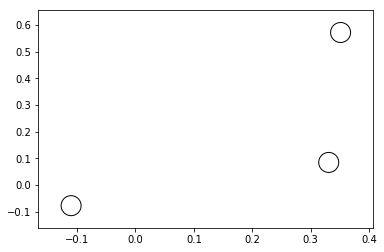

In [130]:
# Create a boolean list of non-zero alphas
ssv = a > 1e-5
print(ssv)
# Select the index of these alphas. They are the support vectors.
ind = np.arange(len(a))[ssv]
# Select the corresponding alphas a, support vectors sv and class labels sv_y
a = a[ssv]
print(a)
sv = X_svm[ssv]
sv_y = y_output[ssv]
 
# Plotting the support vectors
plt.scatter(
    sv[:,0],
    sv[:,1],
    facecolors='none',
    s=400,
    edgecolors='k'
    )

Solution:
$ w = \sum_{n=1}^{N}\alpha_ny_nx_n $

In [131]:
# Computing the weights w_svm
w_svm = np.zeros(X_svm.shape[1])
 
for each in range(len(a)):
    w_svm += a[each] * sv_y[each] * sv[each]
print('w_svm:', w_svm)
 
# Computing the intercept b_svm
b_svm = sv_y[0] - np.dot(w_svm, sv[0])
print('b_svm:', b_svm)

w_svm: [ 6.13587889 -4.35637027]
b_svm: -0.663824131975


**图示分类结果**

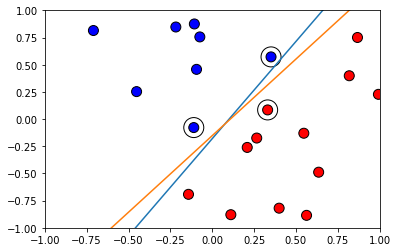

In [132]:
plt.plot([-1,1], [x2_lefttargetf,x2_righttargetf])
plt.axis((-1,1,-1,1))

# Plotting the training points
plt.scatter(
    x1_input,
    x2_input,
    c=y_output,
    cmap='bwr',
    alpha=1,
    s=100,
    edgecolors='k'
    )

plt.scatter(
    sv[:,0],
    sv[:,1],
    facecolors='none',
    s=400,
    edgecolors='k'
    )

# Plot of SVM function
svm_x2_lefttargeth = -(w_svm[0]*(-1)+b_svm)/w_svm[1]
svm_x2_righttargeth = -(w_svm[0]*(1)+b_svm)/w_svm[1]
 
plt.plot([-1,1], [svm_x2_lefttargeth,svm_x2_righttargeth])